# Estimation of Direction of Arrival (DOA) for First Order Ambisonic Audio Files using Artificial Neural Networks

**Pedro Pablo Lucas Bravo**

**pedropl@uio.no**

Return to [file.ipybn](file.ipynb)

Go back to [training.ipybn](training.ipynb)


# Inference

This section is similar to the final section in the [training.ipybn](training.ipynb) notebook with additional visual information for illustrating the error between the actual DOA and the estimated one considering the worst case, the best case, and the nearest case to the mean.

### IMPORTANT

- **If a plot does not appear or is not interactive, try to execute the cell again, since they use nbagg and sometimes it does not render.**

- **The extrated sound events per each case are saved in the folder [ouput](./output). In windows I normally play them with the built-in sound player, which decodes the ambisonic file to binaural properly. I couldn't find something that allows to decode in Python in a right way**

## Packages and Utility Functions

In [1]:
import numpy as np
import pandas as pd
import librosa
import sklearn
import matplotlib.pyplot as plt
import joblib
import random
import soundfile as sf
import os

import time

start_time = time.time()

#Taken from: https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

# Taken from: https://stackoverflow.com/questions/21030391/how-to-normalize-a-numpy-array-to-a-unit-vector
# It normalizes a vector such that the norm is 1
def normalize(v):
    norm=np.linalg.norm(v)
    if norm==0:
        norm=np.finfo(v.dtype).eps
    return v/norm
    
#Taken from: https://stackoverflow.com/questions/27023068/plotting-3d-vectors-using-python-matplotlib
def plot_vectors(v_test, v_pred):
   
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #for vector in vectors:
    #Reference
    v = np.array([0.5,0,0])
    ax.quiver(0,0,0,v[0],v[1],v[2],
            pivot='tail',arrow_length_ratio=0.3, color = 'y')
    #Test
    v = np.array(v_test)
    vlength=np.linalg.norm(v)
    ax.quiver(0,0,0,v[0],v[1],v[2],
            pivot='tail',arrow_length_ratio=0.3/vlength, color = 'b')
    #Predict
    v = np.array(v_pred)
    vlength=np.linalg.norm(v)
    ax.quiver(0,0,0,v[0],v[1],v[2],
            pivot='tail',arrow_length_ratio=0.3/vlength, color = 'r')
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_zlim([-1,1])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()    
    
# Take the sound event related to an example and save it to the output folder
def extract_sound_event(file_name, start_time, end_time, sound_name_on_save):
    sr = 22050
    signal, sr = librosa.load('data/dcase_data/testing/foa_eval/' + file_name + '.wav', sr, mono=False)
    s = int(start_time * sr)
    e = int(end_time * sr)
    sample = signal[:, s:e]
    sf.write('output/' + sound_name_on_save + '.wav', sample.transpose(), sr) 

### Loading Test Data

In [2]:
#Load from file
print('Loading features...')
dataset_test = pd.read_csv('features_test.csv')
num_features = 768
features_test = dataset_test.iloc[:,0:num_features].to_numpy()
target_test = np.zeros((features_test.shape[0],3))
target_test[:,0] = dataset_test['x'] 
target_test[:,1] = dataset_test['y']
target_test[:,2] = dataset_test['z']
print(features_test.shape)
print(target_test.shape)
print('Done!')

Loading features...
(3974, 768)
(3974, 3)
Done!


### Restoring the Model from File

In [3]:
#restoring the classifier model from file
joblib_file = 'doa_model.pkl'
restored_model = joblib.load(joblib_file)

### Predicting

In [4]:
#Predicting from the testing data
target_pred = restored_model.predict(features_test)

### Performance Metrics

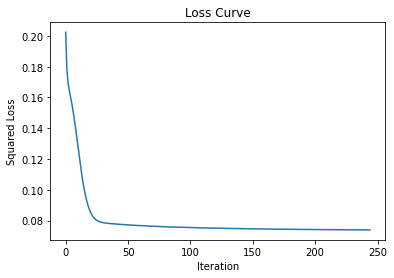

Mean squared error: 0.1155
Mean absolute error: 0.2518
Median absolute error: 0.1966
Coefficient of determination (R2 score): 0.6136
Explained variance score: 0.6138
R2 score on individual targets [0.66936782 0.68238116 0.48891671] 

MEAN ANGLE ERROR: 30.2354 Degrees

TOTAL EXECUTION TIME:  0.9458439350128174  sec


In [5]:
%matplotlib inline
#plotting the loss curve over training iteration 
plt.plot(restored_model.get_params()['steps'][2][1].loss_curve_)
plt.title('Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Squared Loss')
plt.show()

#computing a set of performance metrics

#mean squared error (lower the better)
print('Mean squared error: %.4f'% sklearn.metrics.mean_squared_error(target_test, target_pred))

#mean absolute error (lower the better)
print('Mean absolute error: %.4f'% sklearn.metrics.mean_absolute_error(target_test, target_pred))

#median absolute error (lower the better)
print('Median absolute error: %.4f'% sklearn.metrics.median_absolute_error(target_test, target_pred))

#coefficient of determination (r2 score): 1 is perfect prediction (it can get arbitrary negative)
print('Coefficient of determination (R2 score): %.4f'% sklearn.metrics.r2_score(target_test, target_pred))

#explained variance score: 1 is perfect prediction (it can get arbitrary worse)
print('Explained variance score: %.4f'% sklearn.metrics.explained_variance_score(target_test, target_pred))

#this is is a better represenation of the r2 score when working with multiple outputs
#as it provides a value for each target value
print('R2 score on individual targets',sklearn.metrics.r2_score(target_test, target_pred, multioutput='raw_values'), '\n')

#####----- Delta angle between actual DOA and estimated DOA
deg = []
for d in range(target_test.shape[0]):
    deg = np.append(deg, np.rad2deg(angle_between(target_test[d], target_pred[d])))
print('MEAN ANGLE ERROR: %.4f'% np.mean(deg), 'Degrees\n')

print('TOTAL EXECUTION TIME: ', str(time.time() - start_time), ' sec')

# Illustration of Specific Cases

Below it is shown the worst, the best, and the average case for the solution with their respective angle error and an interactive 3D plot to visualize it. **For every figure the blue vector is the actual DOA and the red one the estimation. The yellow vector is the reference that point to the front.**

In [6]:
def sound_event_demo(index, sound_name):
    print('ANGLE ERROR: %.4f'% deg[index], 'Degrees\n')
    print('Actual DOA [elevation, azimuth]: ', dataset_test['ele'][index], ',', dataset_test['azi'][index])
    #Save sound event to file to check
    extract_sound_event(dataset_test['file_name'][index], dataset_test['start_time'][index], dataset_test['end_time'][index], sound_name)
    #Plot angle error
    %matplotlib nbagg
    plot_vectors(target_test[index], normalize(target_pred[index]))

## The Worst Case

The example that has the maximun angle error will be the worst case, and is presented below:

ANGLE ERROR: 178.3433 Degrees

Actual DOA [elevation, azimuth]:  10 , -180


<IPython.core.display.Javascript object>


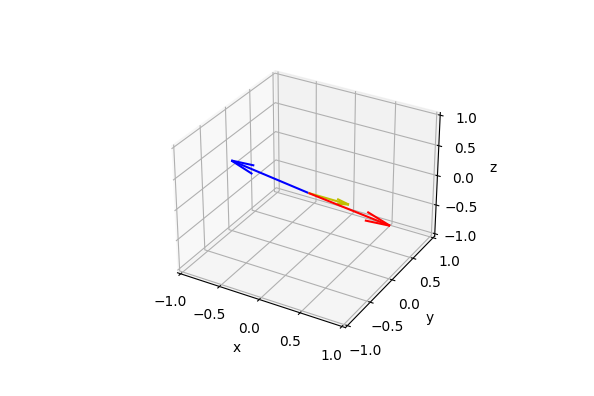

In [12]:
index = np.argmax(deg)
sound_event_demo(index, 'worst')

## The Best Case

The example that has the minimun angle error will be the best estimated case, and is presented below:

ANGLE ERROR: 0.4992 Degrees

Actual DOA [elevation, azimuth]:  10 , -150


<IPython.core.display.Javascript object>


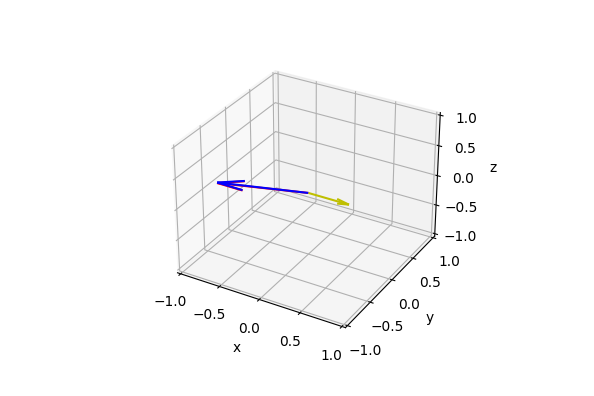

In [13]:
index = np.argmin(deg)
sound_event_demo(index, 'best')

## The Average Case

The example that has the nearest angle error to the mean will be the average estimated case, and is presented below:

ANGLE ERROR: 30.2483 Degrees

Actual DOA [elevation, azimuth]:  -20 , 120


<IPython.core.display.Javascript object>


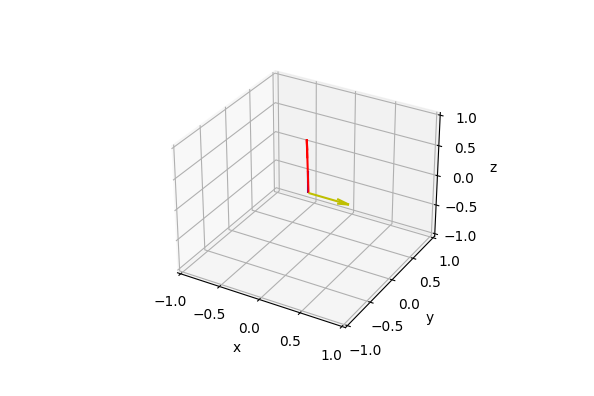

In [14]:
mean = np.mean(deg)
delta = np.abs(deg - mean)
index = np.argmin(delta)
sound_event_demo(index, 'average')

## The Playground

Here we can try any index from the testing data to see the angle error and its visual representation, for now it considers a random index, but it can be changed:

Example #  3964
ANGLE ERROR: 16.5054 Degrees

Actual DOA [elevation, azimuth]:  -20 , -180


<IPython.core.display.Javascript object>


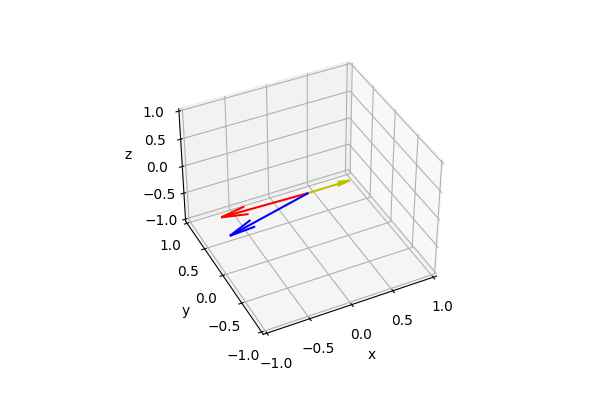

In [15]:
index = random.randrange(target_test.shape[0])
print('Example # ', str(index+1))
sound_event_demo(index, 'custom')

In [11]:
print('TOTAL EXECUTION TIME: ', str(time.time() - start_time), ' sec')

TOTAL EXECUTION TIME:  13.501678705215454  sec


Return to [file.ipybn](file.ipynb)

Go back to [training.ipybn](training.ipynb)